Loading Dependencies:

In [13]:
import pandas as pd
import numpy as np
import os
import cv2 as cv 
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Check if GPU is available:

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9186129142681760976
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5732564992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14401137987732404958
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:05:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


#  Importing the data

In [4]:
# All the folders in the training directory
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_dir = "./data/Training/"
test_dir = "./data/Testing/"

# Initialize image size
IMG_SIZE = 300

# Initialize lists
training_data = []
test_data = []

# Function to label the image arrays
def create_data(data_list, directory):
    # Loop over the folders (categories)
    for i, category in enumerate(categories):
        # Join the paths
        path = os.path.join(directory, category)
        # Read individual images
        for img in os.listdir(path):
            img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
            resized_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data_list.append([resized_array, i])


# Creating the labelled images
create_data(training_data, train_dir)
create_data(test_data, test_dir)

# Print the length
len(training_data)
len(test_data)

394

Shuffle the data since otherwise the neural network doesn't learn very well:

In [5]:
random.shuffle(training_data)
random.shuffle(test_data)

Create the training/testing Y & X:

In [6]:
X_train = []
y_train = []
X_test = []
y_test = []

for features, label in training_data:
    X_train.append(features)
    y_train.append(label)


for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

# Reshaping the images
X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)


As can be seen here it can be quite hard to distuingish between tumors for an untrained eye, while some others can be more easily spotted. Seems like a good case for machine learning:

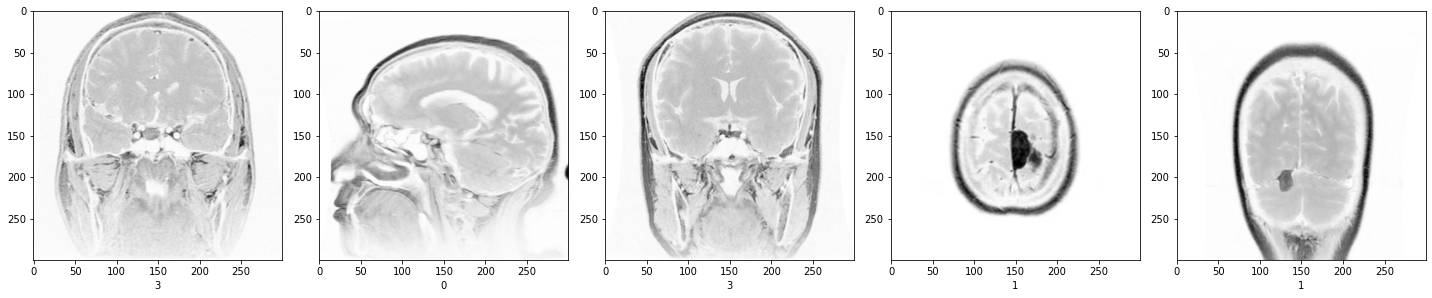

In [7]:
plt.figure(figsize = (20,20));
for i,j in enumerate(X_train):
    if i<5:
        plt.subplot(1,5,i+1)
        plt.imshow(j, cmap="Greys");
        plt.xlabel(y_train[i]);
        plt.tight_layout()
    else:
        break

# Data Augmentation

# Building the Neural Network

In [ ]:
generator = ImageDataGenerator(rotation_range=10, width_shift_range= 0.1, height_shift_range = 0.1, shear_range= 0.15, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size = (5,5), filters = 32, activation ="relu", padding = "same"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(kernel_size = (3,3), filters = 64, activation ="relu", padding = "same"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(kernel_size = (3,3), filters = 128, activation ="relu", padding = "same"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(kernel_size = (4,4), filters = 256, activation ="relu", padding = "same"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dropout(rate = 0.5),
    tf.keras.layers.Dense(4, activation = "softmax")
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [9]:
with tf.device('/gpu:0'):
    history = model.fit(tf.cast(X_train, tf.float32), y_train, batch_size=64, epochs = 20, verbose = 1) 

Epoch 1/20
45/45 [==============================] - 18s 252ms/step - loss: 2.0763 - accuracy: 0.4554
Epoch 2/20
45/45 [==============================] - 7s 164ms/step - loss: 1.0498 - accuracy: 0.5467
Epoch 3/20
45/45 [==============================] - 7s 151ms/step - loss: 0.9382 - accuracy: 0.5923
Epoch 4/20
45/45 [==============================] - 7s 154ms/step - loss: 0.8776 - accuracy: 0.6153
Epoch 5/20
45/45 [==============================] - 7s 160ms/step - loss: 0.8187 - accuracy: 0.6481
Epoch 6/20
45/45 [==============================] - 7s 165ms/step - loss: 0.7968 - accuracy: 0.6411
Epoch 7/20
45/45 [==============================] - 7s 166ms/step - loss: 0.7320 - accuracy: 0.6913
Epoch 8/20
45/45 [==============================] - 8s 169ms/step - loss: 0.7133 - accuracy: 0.6993
Epoch 9/20
45/45 [==============================] - 7s 166ms/step - loss: 0.6662 - accuracy: 0.7247
Epoch 10/20
45/45 [==============================] - 8s 172ms/step - loss: 0.5979 - accuracy: 0.744

Test predictions:

In [10]:
# Getting the probabilities
y_pred = model.predict(X_test)

# Getting the classes
y_pred_classes = np.argmax(y_pred,axis=1)

13/13 [==============================] - 1s 43ms/step


Prediction accuracy:

In [11]:
sum(y_pred_classes == y_test)/len(y_test)

0.7284263959390863